<a href="https://colab.research.google.com/github/hardiksharma2005/Time-series-forcasting/blob/main/Time_Series_Forcasting_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Day 1



In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [22]:
# Step 1 Loading data
ticker = 'GOOGL'
df = yf.download(ticker, start='2019-01-01', end='2024-01-01')

# Keeping only the 'Close' column for simplicity
data = df[['Close']].copy()

/tmp/ipython-input-1985715859.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2019-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


In [23]:
# Step 2 Data preprocessing
print(data.index.dtype)
if data.isnull().sum().sum() > 0:
    data.fillna(method='ffill', inplace=True)

datetime64[ns]


In [24]:
# Step 3 EDA & visualization
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,97.456651,98.507876,96.345809,97.392339,3.365043e+07
std,29.469625,29.782025,29.182392,29.501133,1.498762e+07
min,50.888992,52.106304,50.065219,50.974842,9.312000e+06
25%,69.257956,70.092405,68.272283,69.219984,2.427300e+07
50%,99.220322,100.341852,97.433818,98.783612,2.991775e+07
75%,123.705320,124.966914,122.226366,123.814495,3.780450e+07
max,148.714844,150.410019,147.782417,150.115749,1.331780e+08


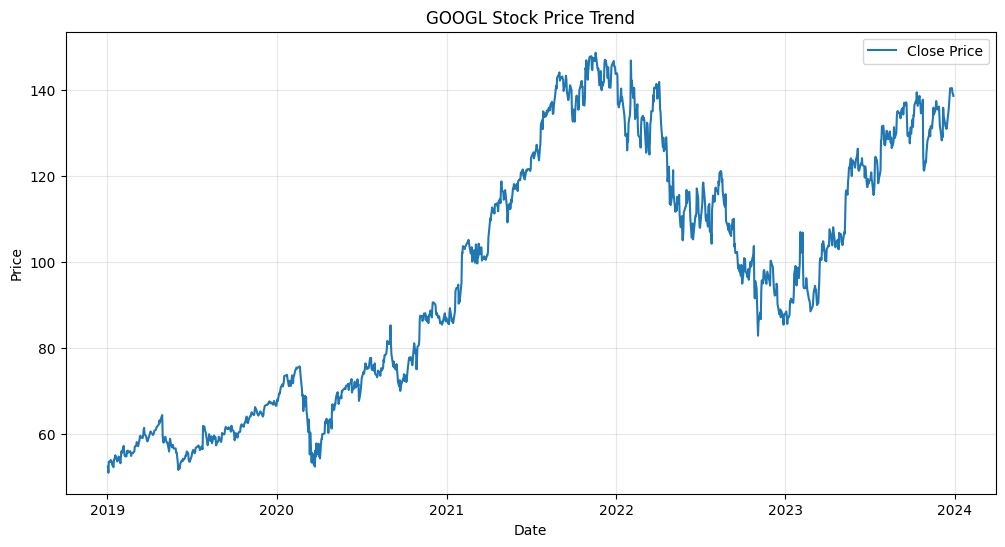

In [25]:
# Visualization of the trend
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='#1f77b4')

plt.title(f"{ticker} Stock Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

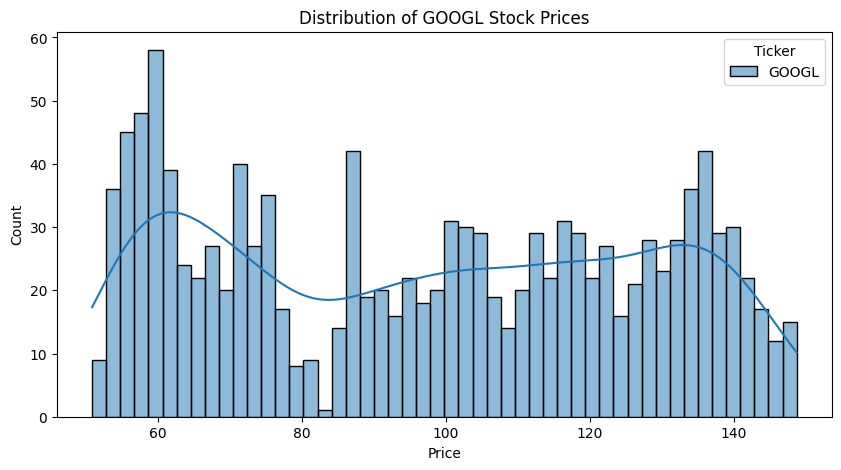

In [26]:
# Distribution of prices
plt.figure(figsize=(10, 5))
sns.histplot(data['Close'], kde=True, color='purple', bins=50)
plt.title(f"Distribution of {ticker} Stock Prices")
plt.xlabel("Price")
plt.show()

Day 2

In [27]:
# calculating moving averages
# Shows short-term sentiment.
data['MA_50'] = data['Close'].rolling(window=50).mean()

# Shows the major long-term trend.
data['MA_200'] = data['Close'].rolling(window=200).mean()

In [28]:
# calculating volatility
data['Volatility'] = data['Close'].rolling(window=20).std()

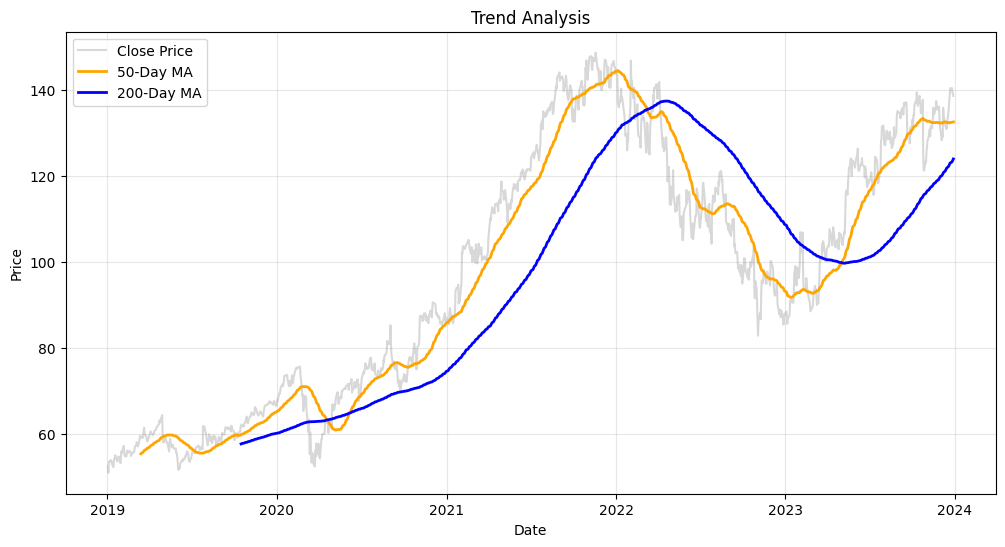

In [29]:
plt.figure(figsize=(12, 6))

plt.plot(data.index, data['Close'], label='Close Price', alpha=0.3, color='gray')

# Plotting moving averages
plt.plot(data.index, data['MA_50'], label='50-Day MA', color='orange', linewidth=2)
plt.plot(data.index, data['MA_200'], label='200-Day MA', color='blue', linewidth=2)

plt.title("Trend Analysis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

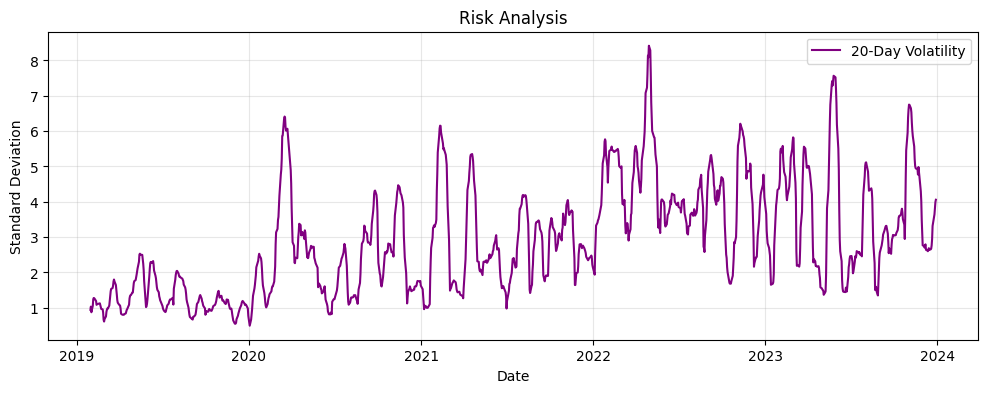

In [30]:
# Plotting the risk
plt.figure(figsize=(12, 4))

plt.plot(data.index, data['Volatility'], label='20-Day Volatility', color='purple')

plt.title("Risk Analysis")
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Day 3

In [31]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [32]:
# The stationarity test (ADF)
result = adfuller(data['Close'])

print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

# Logic: If p-value > 0.05, the data is Non-Stationary (it has a trend).
# We need to subtract today's price from yesterday's (Differencing) to fix it.
if result[1] > 0.05:
    print("Data is NON-STATIONARY (p > 0.05). Differencing is required.")
    d = 1  # This will be our 'd' parameter in ARIMA

    # Create a new column for the differenced data
    data['Diff'] = data['Close'].diff()
else:
    print("Data is STATIONARY (p < 0.05). No differencing needed.")
    d = 0
    data['Diff'] = data['Close'] # Just copy it if it's already good

ADF Statistic: -1.2452
p-value: 0.6538
Data is NON-STATIONARY (p > 0.05). Differencing is required.


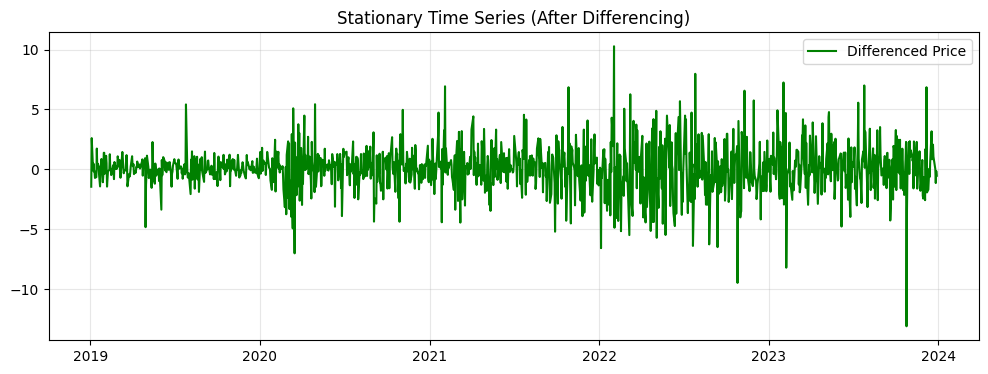

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Diff'], label='Differenced Price', color='green')
plt.title("Stationary Time Series (After Differencing)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

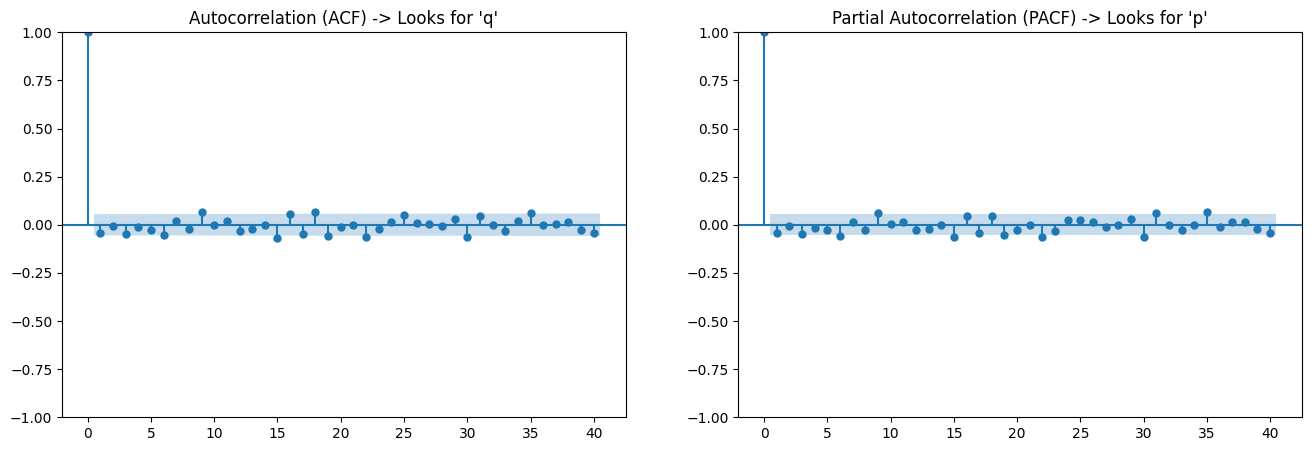

In [38]:
# Finding p and q (ACF/PACF)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# ACF plot
plot_acf(data['Diff'].dropna(), ax=ax1, lags=40)
ax1.set_title("Autocorrelation (ACF) -> Looks for 'q'")

# PACF plot
plot_pacf(data['Diff'].dropna(), ax=ax2, lags=40)
ax2.set_title("Partial Autocorrelation (PACF) -> Looks for 'p'")

plt.show()